In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco

#Config
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
plt.style.use('fivethirtyeight')
#np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [55]:
data = pd.read_excel('data_mrcado.xlsx').set_index('Date')
data.head(3)

,AMZN,MSFT,NVDA,NFLX,V,AAPL,GOOGL
Date,,,,,,,
2019-06-11,1863.699951,130.494232,150.331329,351.269989,169.251297,192.512451,1081.040039
2019-06-12,1855.319946,129.891647,145.793976,345.559998,170.523346,191.899780,1079.099976
2019-06-13,1870.300049,130.711548,147.848221,343.429993,168.297272,191.860229,1091.010010


In [57]:
num_columns = len(data.columns)
#Estos weights deben estar en porcentajes
initial_weights = np.full(shape=num_columns, fill_value = (1/num_columns))

In [58]:
initial_weights

array([0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143])

In [59]:
data_portfolio = data.copy()
data_portfolio['Portfolio'] = np.dot(data_portfolio, initial_weights)
data_pct_change = data_portfolio.pct_change().dropna()
#Creo arrays de Rendimiento diario, anual, dsv_diaria, dsv_anual y sharpe. 
amount = 1000000
risk_free_rate = 0.0068

In [60]:
matrix_info = pd.DataFrame({'Rend_diario': data_pct_change.agg('mean'),
             'Rend_anual': (1 + data_pct_change.agg('mean'))**252 - 1,
             'desv_diaria': data_pct_change.agg('std'),
             'desv_anual': data_pct_change.agg('std')*np.sqrt(252)})

matrix_info['sharpe_ratio'] = (matrix_info['Rend_anual'] - risk_free_rate)/matrix_info['desv_anual']

**Del Portafolio**

Ahora, como tengo que hacer markowitz. Necesito definir: 

1.- El vector de pesos.

2.- La media de retornos.

3.- La matriz de covarianza.

4.- La tasa libre de riesgo.

5.- La función del Ratio de Sharpe.

6.- La función de maximización del ratio de sharpe. 

7- La volatilidad del portafolio, con la funcion que me dé el performance anualizado del portafolio.

8.- La función que me de los pesos que den el portafolio de mínima varianza.

9.- La función que me de los pesos que den el portafolio de máxima rentabilidad

In [61]:
#retornos
returns = data_pct_change.drop('Portfolio',axis=1) #porcentaje
cov_matrix = returns.cov() 
media_retornos = returns.mean() #tambien en porcentaje

In [62]:
def performance_anualizado_portafolio(weights, media_retornos, cov_matrix):
    """
    Me dará los retornos totales de mi portafolio, junto a la desv_standar del mismo
    """
    retornos_totales = np.sum(media_retornos*weights) * 252 #La media de retornos al día, por 252 días.
    desv_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252) #Tengo la dsv stand del portafolio
    return desv_std, retornos_totales

In [63]:
def neg_sharpe_ratio(weights,media_retornos, cov_matrix, risk_free_rate):
    desv_standar_portafolio, retornos_portafolio = performance_anualizado_portafolio(weights, media_retornos, cov_matrix) #Obtengo la desv y retornos totales
    return -(retornos_portafolio - risk_free_rate)/desv_standar_portafolio

In [165]:
def max_sharpe(media_retornos, cov_matrix, risk_free_rate):
    """
    Función de maximización para el ratio de Sharpe
    """
    num_acciones = len(media_retornos)
    args = (media_retornos, cov_matrix, risk_free_rate)
    restricciones = ({'type':'eq','fun':lambda x: np.sum(x)-1}) #Esta es la restricción para que los pesos sumen 1
    limite = (0.0,1.0) #Los limites de los valores de los pesos.
    limites = tuple(limite for accion in range(num_acciones)) #creo N limites
    result = sco.minimize(neg_sharpe_ratio, initial_weights, args=args,
                         method='SLSQP',bounds=limites, constraints=restricciones)
    return result

def volatilidad_portafolio(weights, media_retornos, cov_matrix):
    return performance_anualizado_portafolio(weights, media_retornos, cov_matrix)[0]

def retorno_portafolio(weights, media_retornos, cov_matrix):
    return performance_anualizado_portafolio(weights, media_retornos, cov_matrix)[1]

def neg_retorno_portafolio(weights, media_retornos, cov_matrix):
    return -performance_anualizado_portafolio(weights, media_retornos, cov_matrix)[1]

def varianza_minima(media_retornos, cov_matrix):
    """
    Función de minimización de varianza del portafolio.
    """
    num_acciones = len(media_retornos)
    args = (media_retornos, cov_matrix)
    restricciones = ({'type':'eq','fun': lambda x: np.sum(x) - 1})
    limite = (0.0, 1.0)
    limites = tuple(limite for asset in range(num_acciones))
    
    result_min_varianza = sco.minimize(volatilidad_portafolio, num_acciones*[1./num_acciones,], args=args,
                                     method='SLSQP',bounds=limites,constraints = restricciones)
    return result_min_varianza

def max_rentabilidad(media_retornos, cov_matrix):
    """
    Función de maximización del retorno
    """
    num_acciones = len(media_retornos)
    args = (media_retornos, cov_matrix)
    restricciones = ({'type':'eq','fun': lambda x: np.sum(x) - 1})
    limite = (0.0, 1.0)
    limites = tuple(limite for asset in range(num_acciones))
    
    result_max_retorno = sco.minimize(neg_retorno_portafolio, num_acciones*[1./num_acciones,], args=args,
                                     method='SLSQP',bounds=limites,constraints=restricciones)
    return result_max_retorno

In [166]:
max_rentabilidad(media_retornos, cov_matrix)

     fun: -1.0683868161970678
     jac: array([-0.399, -0.490, -1.068, -0.298, -0.252, -0.686, -0.368])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.000, 0.000, 1.000, 0.000, 0.000, 0.000, 0.000])

In [65]:
#Hallando el portafolio con mínima varianza:
resultados_pesos_min_var = varianza_minima(media_retornos, cov_matrix)
resultados_pesos_min_var.x

array([0.658, 0.000, 0.000, 0.077, 0.155, 0.000, 0.109])

In [66]:
#Hallando el ratio de Sharpe
resultados_pesos_max_sharpe = max_sharpe(media_retornos, cov_matrix, risk_free_rate).x
resultados_pesos_max_sharpe

array([0.000, 0.000, 0.686, 0.000, 0.000, 0.314, 0.000])

##### Ahora intentemos graficar el portafolio con máximo ratio de sharpe

In [108]:
#Haremos primero las funciones para ubicar la frontera eficiente.

def retornos_eficientes(media_retornos, cov_matrix, target):
    num_acciones = len(media_retornos)
    args = (media_retornos, cov_matrix)
    
    #Acá la restricción es el retorno del portafolio, pero con 
    restricciones = ({'type':'eq','fun': lambda x: retorno_portafolio(x, media_retornos, cov_matrix) - target},
                    {'type':'eq', 'fun': lambda x: np.sum(x) - 1})
    
    limites = tuple((0,1) for accion in range(num_acciones))
    
    retornos_eficientes = sco.minimize(volatilidad_portafolio, num_acciones*[1./num_acciones,], args = args, method='SLSQP', bounds = limites, constraints=restricciones)
    
    return retornos_eficientes

def frontera_eficiente(media_retornos, cov_matrix, rango_retornos):
    """
    Esta función me va a calcular varios portafolios eficientes en un dentro de un rango retornos requerido.
    Recuerda que el rango de retornos máximo, será el portafolio que me de más rentabilidad. Por lo tanto, tendré también que optimizar c/r a la rentabilidad.
    """
    eficientes = []
    for retorno in rango_retornos:
        eficientes.append(retornos_eficientes(media_retornos, cov_matrix, retorno))
    return eficientes

In [176]:
def frontera_eficiente_sharpe_var(media_retornos, cov_matrix, risk_free_rate,data):
    
    #----------------------------Optimizaciones-------------------------
    sharpe_maximo = max_sharpe(media_retornos, cov_matrix, risk_free_rate)
    sharpe_dsv, sharpe_retornos = performance_anualizado_portafolio(weights=sharpe_maximo['x'], #Los weights serán los valores que me botan la maximización
                                                                    media_retornos = media_retornos, cov_matrix = cov_matrix)
    sharpe_max_posicion = pd.DataFrame(sharpe_maximo['x'], index = data.columns, columns=['Posicion'])
    sharpe_max_posicion['Posicion'] = [round(i*100,2) for i in sharpe_max_posicion['Posicion']]
    sharpe_max_posicion = sharpe_max_posicion.T
    
    volat_min = varianza_minima(media_retornos, cov_matrix)
    dsv_min_var, dsv_min_retornos = performance_anualizado_portafolio(weights=volat_min['x'], media_retornos=media_retornos, cov_matrix=cov_matrix)
    volat_min_posicion = pd.DataFrame(volat_min['x'], index=data.columns, columns=['Posicion'])
    volat_min_posicion['Posicion'] = [round(i*100,2) for i in volat_min_posicion['Posicion']]
    volat_min_posicion = volat_min_posicion.T
    
    max_retorno = max_rentabilidad(media_retornos, cov_matrix)
    dsv_max_retorno, total_retorno_max = performance_anualizado_portafolio(weights=max_retorno['x'], media_retornos = media_retornos, cov_matrix=cov_matrix)
    max_retorno_posicion = pd.DataFrame(max_retorno['x'], index=data.columns, columns=['Posicion'])
    max_retorno_posicion['Posicion'] = [round(i*100,2) for i in max_retorno_posicion['Posicion']]
    max_retorno_posicion = max_retorno_posicion.T
    
    cambio_pct_stocks = data.pct_change()
    retornos_medios_stocks = cambio_pct_stocks.mean()
    volatilidad_anual_stocks = np.std(cambio_pct_stocks) * np.sqrt(252)
    retornos_anual = media_retornos * 252
    
    #Ahora hacemos la figura
    fig, ax = plt.subplots(figsize=(10,7))
    ax.scatter(volatilidad_anual_stocks, retornos_anual, marker='o',s=200)
    
    #Pongo los nombres a cada uno de los puntos.
    for i, txt in enumerate(data.columns):
        ax.annotate(txt, (volatilidad_anual_stocks[i], retornos_anual[i]), xytext=(10,0), textcoords='offset points')
    
    #Gráficos de max_sharpe y varianza minima
    ax.scatter(sharpe_dsv, sharpe_retornos, marker='*', color='r',s=500, label='Maximo Ratios de Sharpe')
    ax.scatter(dsv_min_var, dsv_min_retornos, marker='*', color='g',s=500, label='Minima Volatilidad')
    
    #Ajustamos la máxima volatilidad de algún stock para el gráfico.
    target = np.linspace(dsv_min_retornos, total_retorno_max, 50) #Esta linea me va a generar un array de 50 muestras con límite de portafolio de máxima rentabilidad.
    
    portafolios_eficientes = frontera_eficiente(media_retornos, cov_matrix, target)
    
    #Grafico todos los portafolios eficientes.
    ax.plot([p['fun'] for p in portafolios_eficientes], target, linestyle='-.', color='black', label='frontera eficiente')
    
    ax.set_title('Optimización de Portafolio')
    ax.set_xlabel('Volatilidad Anualizada')
    ax.set_ylabel('Retornos Anualizados')
    ax.legend(labelspacing=0.8)

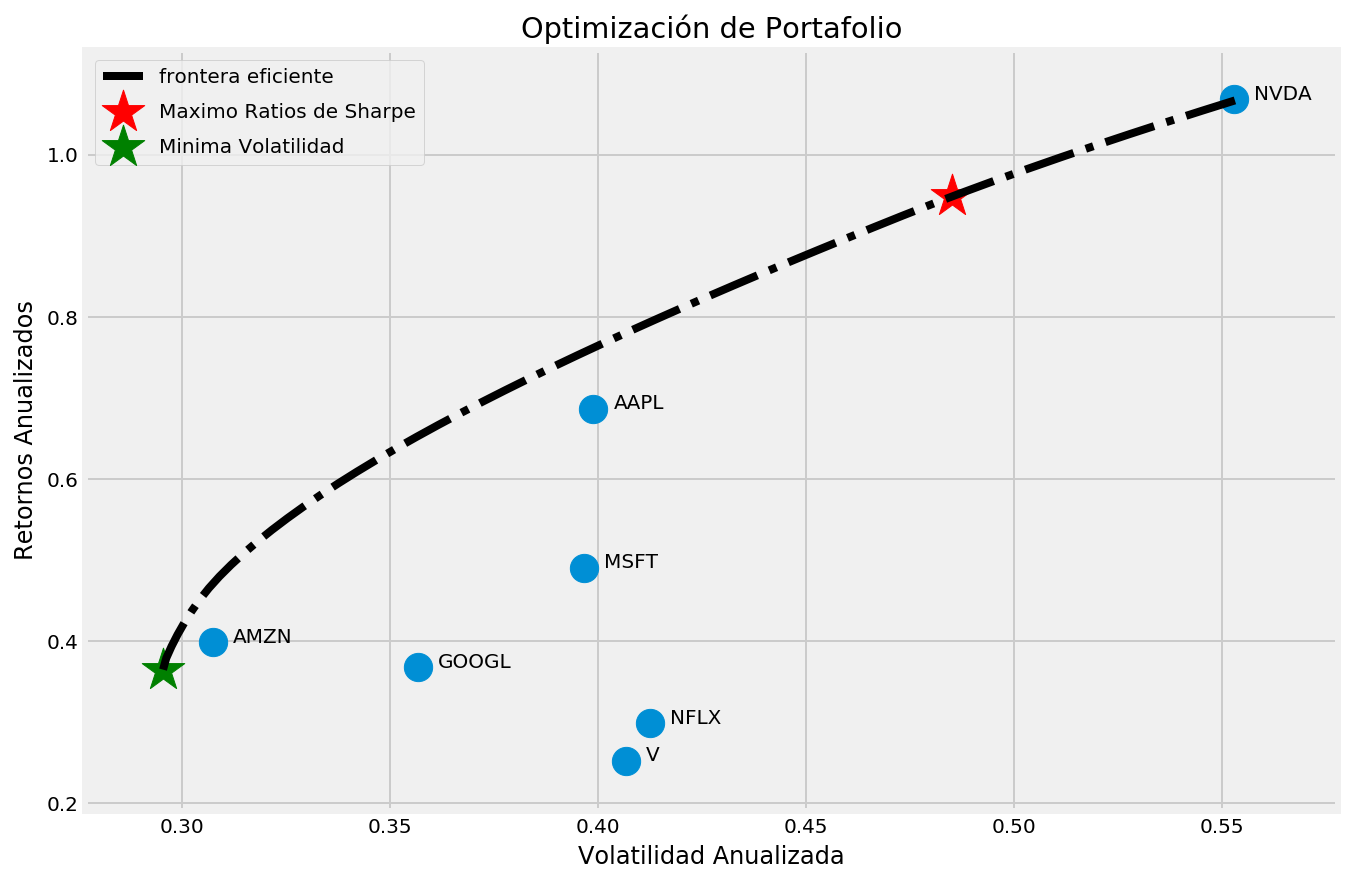

In [179]:
frontera_eficiente_sharpe_var(media_retornos, cov_matrix, risk_free_rate,data)